In [44]:
from pool import AMMPool, AMMPoolHistory, CPMM

In [45]:
import pandas as pd 

**Define Pools to study and initialize**

In [46]:
# Define token0=USDC and token1=WETH
token0 = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'
token1 = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'

**Get Uni trades stream**  

In [47]:
from datastreams.datastream import Streamer

query_size = 10000

# instantiate Streamer object. 
# Note - unlike the cow queries, univ3 does not require multiple streamer instantations because the swaps field path is reset each iteration. 
# If the Cow queries were updated to use the same method, we could use the same streamer object for all queries.
univ3_ds = Streamer('https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum')

# get a query field path from the query dictionary which is automatically populated in the Streamer object
uni_swaps_fp = univ3_ds.queryDict.get('swaps')

# define query path and parameters 
uni_swaps_qp = uni_swaps_fp(
        first=query_size, 
        orderBy='timestamp',
        orderDirection='asc',
        where = {'timestamp_gt':1643673600, 'pool': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'} 
        )

# run query
uni_swaps_df = univ3_ds.runQuery(uni_swaps_qp)

FIELD - swaps


In [48]:
uni_swaps_df.shape

(10000, 20)

In [49]:
uni_swaps_df.dtypes

swaps_id               object
swaps_hash             object
swaps_nonce             int64
swaps_logIndex          int64
swaps_gasLimit          int64
swaps_gasUsed          object
swaps_gasPrice          int64
swaps_protocol_id      object
swaps_account_id       object
swaps_pool_id          object
swaps_blockNumber       int64
swaps_timestamp         int64
swaps_tick              int64
swaps_tokenIn_id       object
swaps_amountIn         object
swaps_amountInUSD     float64
swaps_tokenOut_id      object
swaps_amountOut        object
swaps_amountOutUSD    float64
endpoint               object
dtype: object

In [50]:
uni_swaps_df.head(5)

,swaps_id,swaps_hash,swaps_nonce,swaps_logIndex,swaps_gasLimit,swaps_gasUsed,swaps_gasPrice,swaps_protocol_id,swaps_account_id,swaps_pool_id,swaps_blockNumber,swaps_timestamp,swaps_tick,swaps_tokenIn_id,swaps_amountIn,swaps_amountInUSD,swaps_tokenOut_id,swaps_amountOut,swaps_amountOutUSD,endpoint
0,0xc500098c60135dfa8c5aded8a9ffddf95d0422993007...,0xc500098c60135dfa8c5aded8a9ffddf95d0422993007...,7236,66,1200000,None,243310839517,0x1f98431c8ad98523631ae4a59f267346ea31f984,0x60b86af869f23aeb552fb7f3cabd11b829f6ab2f,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,14116768,1643673723,197369,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,127681606843910411476,343127.995251,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,341883139095,341883.139095,uniswap-v3-ethereum
1,0x61b6e708eae24a14f75614fed90d53343a08d844789f...,0x61b6e708eae24a14f75614fed90d53343a08d844789f...,34,239,630062,None,139345402218,0x1f98431c8ad98523631ae4a59f267346ea31f984,0xb6398fad2f8d238afd3a522a8ceafd400e71ef62,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,14116795,1643673948,197369,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1097382974817921891,2945.362647,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,2936510663,2936.510663,uniswap-v3-ethereum
2,0x78cf3e16e65e25d456192ad57c1bb665534fe7c38cc3...,0x78cf3e16e65e25d456192ad57c1bb665534fe7c38cc3...,8187,147,380178,None,171184009666,0x1f98431c8ad98523631ae4a59f267346ea31f984,0x30d6c6419cff37c41d93605b2d4d3c79329dc5b3,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,14116802,1643674049,197352,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,457538400000,457538.400000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,169817246222135447688,455782.502709,uniswap-v3-ethereum
3,0xfeab49f705dfe5667373cedeb8af0b4608547131b98e...,0xfeab49f705dfe5667373cedeb8af0b4608547131b98e...,2505,49,380178,None,195208384468,0x1f98431c8ad98523631ae4a59f267346ea31f984,0x316c8fa8607ba1be5eb12c2c02b811b48c86778e,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,14116806,1643674124,197341,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,304930800000,304930.800000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,113017931108396951560,303845.861151,uniswap-v3-ethereum
4,0xb2daa53ef2e9329bb47bd8f56f04c7a8fb87d92d8398...,0xb2daa53ef2e9329bb47bd8f56f04c7a8fb87d92d8398...,11433,115,1200000,None,176045958490,0x1f98431c8ad98523631ae4a59f267346ea31f984,0xd006ad343886254359dc87aa5e1753446072fd50,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,14116808,1643674146,197297,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,762505891677,762505.891677,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,281845732056918124330,758584.016556,uniswap-v3-ethereum


In [51]:
# Find the first and last value in the timestamp column
first_timestamp_uni = uni_swaps_df['swaps_timestamp'].min()
last_timestamp_uni = uni_swaps_df['swaps_timestamp'].max()

In [52]:
first_timestamp_uni

1643673723

In [53]:
last_timestamp_uni

1645732238

**get chainlink pricing to value pools**

In [54]:
# load streamer class
chain_ds = Streamer('https://api.thegraph.com/subgraphs/name/openpredict/chainlink-prices-subgraph')

In [55]:
chain_price_feed = "ETH/USD"

In [56]:
chain_dfs_list = []

In [57]:
# get a query field path from the query dictionary which is automatically populated in the Streamer object
chain_fp = chain_ds.queryDict.get('prices')

# add parameters to the settlements_qp.
chain_qp = chain_fp(
    first= 10000,
    orderBy='timestamp',
    orderDirection='asc',
    where = {'timestamp_gt':1643673600, 'assetPair': chain_price_feed}
    )

# run query
chain_df = chain_ds.runQuery(chain_qp)

FIELD - prices


In [58]:
# drop prices_id, endpoint. 
chain_df = chain_df.drop(['prices_id', 'endpoint'], axis=1)
# divide prices_price by 1e8 to get the price in USD
chain_df['prices_price'] = chain_df['prices_price'] / 10 ** 8

In [59]:
chain_df.shape

(10000, 3)

In [60]:
chain_df.head(5)

,prices_assetPair_id,prices_timestamp,prices_price
0,ETH/USD,1643676926,2691.315867
1,ETH/USD,1643680542,2686.346068
2,ETH/USD,1643683201,2700.412022
3,ETH/USD,1643684135,2711.714351
4,ETH/USD,1643685147,2731.076527


In [61]:
print(chain_df.columns) 

Index(['prices_assetPair_id', 'prices_timestamp', 'prices_price'], dtype='object')


In [62]:
# Find the first and last value in the timestamp column
first_timestamp = chain_df['prices_timestamp'].min()
last_timestamp = chain_df['prices_timestamp'].max()

In [63]:
first_timestamp

1643676926

In [64]:
last_timestamp

1657307781

In [65]:
timestamps = pd.DataFrame({'prices_timestamp': range(first_timestamp, last_timestamp + 1)})

In [66]:
timestamps.shape

(13630856, 1)

In [67]:
chain_df = pd.merge(timestamps, chain_df, on='prices_timestamp', how='left')

In [68]:
chain_df.head(5)

,prices_timestamp,prices_assetPair_id,prices_price
0,1643676926,ETH/USD,2691.315867
1,1643676927,NaN,NaN
2,1643676928,NaN,NaN
3,1643676929,NaN,NaN
4,1643676930,NaN,NaN


In [69]:
# Forward-fill missing values
chain_df.fillna(method='ffill', inplace=True)

In [70]:
chain_df.shape

(13630856, 3)

In [71]:
chain_df

,prices_timestamp,prices_assetPair_id,prices_price
0,1643676926,ETH/USD,2691.315867
1,1643676927,ETH/USD,2691.315867
2,1643676928,ETH/USD,2691.315867
3,1643676929,ETH/USD,2691.315867
4,1643676930,ETH/USD,2691.315867
...,...,...,...
13630851,1657307777,ETH/USD,1222.793400
13630852,1657307778,ETH/USD,1222.793400
13630853,1657307779,ETH/USD,1222.793400
13630854,1657307780,ETH/USD,1222.793400


**1.Simple AMM. SWAP ALL** 

In [72]:
# Create an instance of AMMPoolHistory 
feedlot1 = AMMPoolHistory(100000000000000000000000000, 40000000000000000000)

In [73]:
# Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    # Determine if the swap is a buy or a sell
    token_in = row['swaps_tokenIn_id']
    token_out = row['swaps_tokenOut_id']
    is_buy = token_in == token0 and token_out == token1
    
    # Extract the amountIn, amountOut, and timestamp
    if is_buy:
        amt0 = row['swaps_amountIn']
        amt1 = row['swaps_amountOut']
    else:
        amt0 = row['swaps_amountOut']
        amt1 = row['swaps_amountIn']
    ts = row['swaps_timestamp']
    
    print('amt0', amt0)
    print('amt1', amt1)
    print('ts', ts)
    
    # Run the swap function on the AMM pool
    feedlot1.swap(amt0, amt1, ts)

amt0 341883139095
amt1 127681606843910411476
ts 1643673723
amt0 2936510663
amt1 1097382974817921891
ts 1643673948
amt0 457538400000
amt1 169817246222135447688
ts 1643674049
amt0 304930800000
amt1 113017931108396951560
ts 1643674124
amt0 762505891677
amt1 281845732056918124330
ts 1643674146
amt0 257727468211
amt1 95696253150428069347
ts 1643674727
amt0 200281668339
amt1 74466811204098883584
ts 1643674736
amt0 402092292550
amt1 149760000000000000000
ts 1643674815
amt0 3998000000
amt1 1481502067243551508
ts 1643675848
amt0 23400000000
amt1 8670686563469595178
ts 1643677266
amt0 249755238047
amt1 92491100000000000000
ts 1643677640
amt0 125000000000
amt1 46242543754865790256
ts 1643677829
amt0 13390190827
amt1 4981789650191380000
ts 1643677886
amt0 19737502404
amt1 7344011149985071500
ts 1643678003
amt0 10000000000
amt1 3698656356167690573
ts 1643678182
amt0 7544004915
amt1 2790123960191991217
ts 1643678222
amt0 1149231361
amt1 425028333296472674
ts 1643678488
amt0 184435693324
amt1 6817388

amt0 152667662163
amt1 50000000000000000000
ts 1644226610
amt0 7402299289
amt1 2424803286939097532
ts 1644226768
amt0 920935494
amt1 299869934292988766
ts 1644227810
amt0 40000000000
amt1 13023914895642220298
ts 1644227880
amt0 1837327000
amt1 598198561775912573
ts 1644227948
amt0 284663821956
amt1 92648011278978028055
ts 1644228105
amt0 174798006011
amt1 56858005636206988444
ts 1644228116
amt0 2342500000
amt1 761796354195644991
ts 1644228988
amt0 34402312987
amt1 11187345522455552300
ts 1644230156
amt0 61300000
amt1 19933393319076561
ts 1644230198
amt0 27678540452
amt1 9000000000000000000
ts 1644230238
amt0 5941072762
amt1 1931889959464709762
ts 1644230238
amt0 4490000000
amt1 1459917319605787161
ts 1644230248
amt0 4063660077
amt1 1321279400752413680
ts 1644230315
amt0 15378119480
amt1 5000000000000000000
ts 1644230315
amt0 31125656292
amt1 10119525097133706924
ts 1644230398
amt0 31125656292
amt1 10118740399736999283
ts 1644230472
amt0 3076171655
amt1 1000000000000000000
ts 1644230537

amt0 329485465885
amt1 110259078098625000000
ts 1644607461
amt0 20608239334
amt1 6900000000000000000
ts 1644607487
amt0 746632416029
amt1 250276307391340267358
ts 1644607507
amt0 29797260842
amt1 10000000000000000000
ts 1644607507
amt0 29794569745
amt1 10000000000000000000
ts 1644607507
amt0 8937604058
amt1 3000000000000000000
ts 1644607533
amt0 8937846214
amt1 3000000000000000000
ts 1644607533
amt0 1191662245
amt1 400000000000000000
ts 1644607533
amt0 20853392476
amt1 7000000000000000000
ts 1644607579
amt0 20402718243
amt1 6800114932248242479
ts 1644607997
amt0 368648500000
amt1 122940777826343917647
ts 1644607997
amt0 805473900000
amt1 268125610826644383039
ts 1644608020
amt0 1011015200611
amt1 335704008652096114299
ts 1644608022
amt0 380133667286
amt1 126000000000000000000
ts 1644608171
amt0 476798111666
amt1 157869488023585035981
ts 1644608171
amt0 293315400000
amt1 97023258164509799820
ts 1644608202
amt0 10000000000
amt1 3306545953280694502
ts 1644608219
amt0 16242343384
amt1 5407

amt0 288373541947
amt1 100037460850500000000
ts 1645136242
amt0 4268613753
amt1 1481468626740188860
ts 1645136296
amt0 5762380984
amt1 2000000000000000000
ts 1645136366
amt0 11525072989
amt1 4000000000000000000
ts 1645136366
amt0 5474165911
amt1 1900000000000000000
ts 1645136423
amt0 3767000000
amt1 1307491481721432574
ts 1645136423
amt0 986505648
amt1 342404608459818940
ts 1645136423
amt0 4283766134
amt1 1486875000000000000
ts 1645136461
amt0 4978193938
amt1 1727932596057639746
ts 1645136487
amt0 523097815736
amt1 181717212543547527221
ts 1645136590
amt0 278989757
amt1 96996576750000000
ts 1645136590
amt0 7462064972
amt1 2594373065208402389
ts 1645136668
amt0 35950683686
amt1 12500000000000000000
ts 1645136687
amt0 836844493
amt1 290986328413660090
ts 1645136687
amt0 66234193882
amt1 23033269709260373439
ts 1645136687
amt0 28751612118
amt1 10000000000000000000
ts 1645136693
amt0 4263540679
amt1 1482964028895834748
ts 1645136751
amt0 2852265721
amt1 985157979641350480
ts 1645137427
amt

amt0 253378800000
amt1 100161571126412200209
ts 1645517231
amt0 154016100000
amt1 60837072703736382357
ts 1645517286
amt0 249189554523
amt1 98357365092068915710
ts 1645517402
amt0 436538406558
amt1 172086523214800519198
ts 1645517545
amt0 208457100000
amt1 82077003133014959378
ts 1645518283
amt0 3719914592
amt1 1464087085129763829
ts 1645518297
amt0 90954000000
amt1 35791469374855059352
ts 1645518458
amt0 108375300000
amt1 42631202840714269364
ts 1645518536
amt0 121884300000
amt1 47924761300214299906
ts 1645518548
amt0 204148476344
amt1 80222607652270675833
ts 1645518562
amt0 1470599078
amt1 577670226047122228
ts 1645518786
amt0 14000000000
amt1 5499223274836996086
ts 1645519973
amt0 1000000000
amt1 392790810886605910
ts 1645520008
amt0 225077400000
amt1 88371538540707443687
ts 1645520028
amt0 3333000000
amt1 1308076616777108939
ts 1645520041
amt0 1349479715061
amt1 528304607242067846487
ts 1645520226
amt0 248794980094
amt1 97789606299204313504
ts 1645520764
amt0 1955059484
amt1 768793

In [74]:
results1 = pd.DataFrame(feedlot1.history)

In [75]:
results1.shape

(10001, 3)

In [76]:
results1.head(5)

,ts,reserve0,reserve1
0,0,100000000000000000000000000,40000000000000000000
1,1643673723,100000000000000341883139095,167681606843910411476
2,1643673948,100000000000000344819649758,168778989818728333367
3,1643674049,100000000000000802358049758,338596236040863781055
4,1643674124,100000000000001107288849758,451614167149260732615


In [77]:
merged1_df = pd.merge(results1, chain_df, left_on='ts', right_on='prices_timestamp')
merged1_df.rename(columns={'prices_price': 'chainlink_price'}, inplace=True)


In [78]:
merged1_df

,ts,reserve0,reserve1,prices_timestamp,prices_assetPair_id,chainlink_price
0,1643677266,100000000000002757294170535,1063535152191418956562,1643677266,ETH/USD,2691.315867
1,1643677640,100000000000003007049408582,1156026252191418956562,1643677640,ETH/USD,2691.315867
2,1643677829,100000000000003132049408582,1202268795946284746818,1643677829,ETH/USD,2691.315867
3,1643677886,100000000000003145439599409,1207250585596476126818,1643677886,ETH/USD,2691.315867
4,1643678003,100000000000003165177101813,1214594596746461198318,1643678003,ETH/USD,2691.315867
...,...,...,...,...,...,...
9986,1645731605,100000000002103145912576390,741946147188885734172286,1645731605,ETH/USD,2554.168141
9987,1645731622,100000000002103258412576390,741989830800598904703564,1645731622,ETH/USD,2554.168141
9988,1645732198,100000000002103358379325270,742028623683262857688549,1645732198,ETH/USD,2567.478087
9989,1645732198,100000000002103401697378376,742045438592121811724194,1645732198,ETH/USD,2567.478087


In [79]:
merged1_df['value'] = merged1_df['reserve1']*merged1_df['chainlink_price']/10**18

In [80]:
merged1_df

,ts,reserve0,reserve1,prices_timestamp,prices_assetPair_id,chainlink_price,value
0,1643677266,100000000000002757294170535,1063535152191418956562,1643677266,ETH/USD,2691.315867,2862309.029918
1,1643677640,100000000000003007049408582,1156026252191418956562,1643677640,ETH/USD,2691.315867,3111231.794879
2,1643677829,100000000000003132049408582,1202268795946284746818,1643677829,ETH/USD,2691.315867,3235685.086605
3,1643677886,100000000000003145439599409,1207250585596476126818,1643677886,ETH/USD,2691.315867,3249092.656135
4,1643678003,100000000000003165177101813,1214594596746461198318,1643678003,ETH/USD,2691.315867,3268857.709868
...,...,...,...,...,...,...,...
9986,1645731605,100000000002103145912576390,741946147188885734172286,1645731605,ETH/USD,2554.168141,1895055211.47271
9987,1645731622,100000000002103258412576390,741989830800598904703564,1645731622,ETH/USD,2554.168141,1895166786.76203
9988,1645732198,100000000002103358379325270,742028623683262857688549,1645732198,ETH/USD,2567.478087,1905142231.151923
9989,1645732198,100000000002103401697378376,742045438592121811724194,1645732198,ETH/USD,2567.478087,1905185403.061952


In [84]:
merged1_df.isna().sum()

ts                     0
reserve0               0
reserve1               0
prices_timestamp       0
prices_assetPair_id    0
chainlink_price        0
value                  0
dtype: int64

Text(0, 0.5, 'Value')

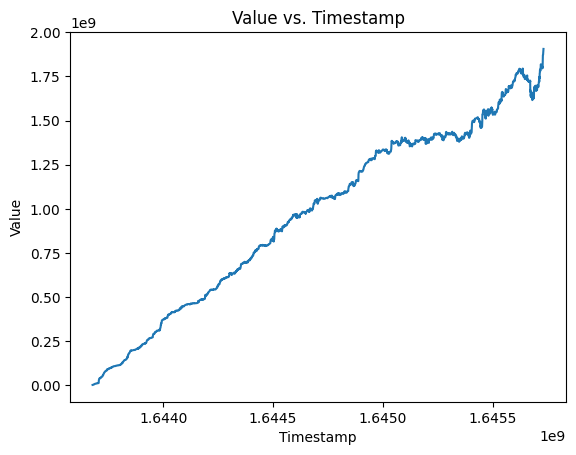

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(merged1_df['ts'], merged1_df['value'])
ax.set_title('Value vs. Timestamp')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')
#fig.savefig('value_vs_timestamp.png', dpi=300)


**OraclePool AMM**

**get cow trades for oracle pricing** 

In [112]:
cow_ds = Streamer('https://api.thegraph.com/subgraphs/name/cowprotocol/cow')

# get COW trades 

trades_fp = cow_ds.queryDict.get('trades')

# trades query path that gets token a -> token b trades
trades_qp = trades_fp(
    first=10000,
    orderBy='timestamp',
    orderDirection='asc',
    where={'timestamp_gt':1643673600, 'sellToken':'0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
           'buyToken':'0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
    }
)

# run query
trades_df = cow_ds.runQuery(trades_qp)

FIELD - trades


In [113]:
trades_df.shape

(6691, 16)

In [114]:
trades_df.head(5)

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_settlement_id,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_order_id,trades_buyAmountEth,trades_sellAmountEth,trades_buyAmountUsd,trades_sellAmountUsd,endpoint
0,0xc8379eed6c50d2133f96a4e98d7629f767ad5c94fcde...,1643677243,131486015070,33214319,0x94ea5a6b74dfd23f254e178935edf31fc8bed500617f...,0x94ea5a6b74dfd23f254e178935edf31fc8bed500617f...,80383518062240036,250000000,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xc8379eed6c50d2133f96a4e98d7629f767ad5c94fcde...,0.080384,0.092918,216.274782,250.000000,cow
1,0x9dde9bf9a979a92af1aaf08d91c4ccf790e118380137...,1643692256,123311573622,47093955,0xb9fcc63c5c1b83b6e41999d41282e0f7dbf69c4a87cb...,0xb9fcc63c5c1b83b6e41999d41282e0f7dbf69c4a87cb...,1804107117913519403,5000000000,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x9dde9bf9a979a92af1aaf08d91c4ccf790e118380137...,1.804107,1.820594,4954.722065,5000.000000,cow
2,0x5a0ed80df1146b858c67a3fd08b8cf42134e7127c050...,1643699916,120586162991,39652676,0xc31eff40ad783a1c282a85bc4f0e5134d35c21992444...,0xc31eff40ad783a1c282a85bc4f0e5134d35c21992444...,722840370145690884,2024247611,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x5a0ed80df1146b858c67a3fd08b8cf42134e7127c050...,0.722840,0.739258,1979.293174,2024.247611,cow
3,0x10fc01b7ea9886bd60947b635f9f975b88c04456bafc...,1643705065,80841326676,37470274,0xebd4a7bc782f952e674ea22f30178f1b8adfe8ec3e83...,0xebd4a7bc782f952e674ea22f30178f1b8adfe8ec3e83...,38851505045821867232,106794792848,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x10fc01b7ea9886bd60947b635f9f975b88c04456bafc...,38.851505,38.856221,106781.831208,106794.792848,cow
4,0x9099795d05dcc1a02c7dca08414e4105df88f8348658...,1643709518,106782879992,44653587,0xb9bb56b417504f26cedc21dcbd3f3dc996b81ab82ac0...,0xb9bb56b417504f26cedc21dcbd3f3dc996b81ab82ac0...,25000000000000000000,68391886148,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x9099795d05dcc1a02c7dca08414e4105df88f8348658...,25.000000,24.969040,68476.687172,68391.886148,cow


In [115]:
# Set query size large enough to retrieve all tokens in the graph
query_size = 10000

token_fp = cow_ds.queryDict.get('tokens')

# add parameters to the settlements_qp.
token_qp = token_fp(
    first=query_size,
)

# run query
token_df = cow_ds.runQuery(token_qp)


FIELD - tokens


In [116]:
token_df.shape

(2967, 13)

In [117]:
# Merge1 on sell token address.  x = sell token 

merged_df = pd.merge(trades_df, token_df, left_on='trades_sellToken_id', right_on='tokens_address')

merged_df.shape

(6691, 29)

In [118]:
# Merge2 on buy token address.  y = buy token 
cow_df = pd.merge(merged_df, token_df, left_on='trades_buyToken_id', right_on='tokens_address')

cow_df.shape

(6691, 42)

In [119]:
cow_df.dtypes

trades_id                        object
trades_timestamp                  int64
trades_gasPrice                   int64
trades_feeAmount                  int64
trades_txHash                    object
trades_settlement_id             object
trades_buyAmount                 object
trades_sellAmount                 int64
trades_sellToken_id              object
trades_buyToken_id               object
trades_order_id                  object
trades_buyAmountEth             float64
trades_sellAmountEth            float64
trades_buyAmountUsd             float64
trades_sellAmountUsd            float64
endpoint_x                       object
tokens_id_x                      object
tokens_address_x                 object
tokens_firstTradeTimestamp_x      int64
tokens_name_x                    object
tokens_symbol_x                  object
tokens_decimals_x                 int64
tokens_totalVolume_x             object
tokens_priceEth_x               float64
tokens_priceUsd_x               float64


In [120]:
# calculate buy and sell amounts from the correct decimal 
cow_df['sell_amount'] = cow_df.apply(lambda x: x['trades_sellAmount'] / (10**x['tokens_decimals_x']), axis=1)
cow_df['buy_amount'] = cow_df.apply(lambda x: x['trades_buyAmount'] / (10**x['tokens_decimals_y']), axis=1)

In [121]:
# calculate COW price defined sell amount / buy amount
cow_df['cow_price'] = cow_df['sell_amount'] / cow_df['buy_amount']

In [122]:
cow_df

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_settlement_id,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,...,tokens_totalVolume_y,tokens_priceEth_y,tokens_priceUsd_y,tokens_numberOfTrades_y,tokens_totalVolumeUsd_y,tokens_totalVolumeEth_y,endpoint,sell_amount,buy_amount,cow_price
0,0xc8379eed6c50d2133f96a4e98d7629f767ad5c94fcde...,1643677243,131486015070,33214319,0x94ea5a6b74dfd23f254e178935edf31fc8bed500617f...,0x94ea5a6b74dfd23f254e178935edf31fc8bed500617f...,80383518062240036,250000000,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2419302988399033368872321,1.0,1535.79973,133289,4.923658e+09,2.419303e+06,cow,250.000000,0.080384,3110.090302
1,0x9dde9bf9a979a92af1aaf08d91c4ccf790e118380137...,1643692256,123311573622,47093955,0xb9fcc63c5c1b83b6e41999d41282e0f7dbf69c4a87cb...,0xb9fcc63c5c1b83b6e41999d41282e0f7dbf69c4a87cb...,1804107117913519403,5000000000,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2419302988399033368872321,1.0,1535.79973,133289,4.923658e+09,2.419303e+06,cow,5000.000000,1.804107,2771.454062
2,0x5a0ed80df1146b858c67a3fd08b8cf42134e7127c050...,1643699916,120586162991,39652676,0xc31eff40ad783a1c282a85bc4f0e5134d35c21992444...,0xc31eff40ad783a1c282a85bc4f0e5134d35c21992444...,722840370145690884,2024247611,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2419302988399033368872321,1.0,1535.79973,133289,4.923658e+09,2.419303e+06,cow,2024.247611,0.722840,2800.407524
3,0x10fc01b7ea9886bd60947b635f9f975b88c04456bafc...,1643705065,80841326676,37470274,0xebd4a7bc782f952e674ea22f30178f1b8adfe8ec3e83...,0xebd4a7bc782f952e674ea22f30178f1b8adfe8ec3e83...,38851505045821867232,106794792848,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2419302988399033368872321,1.0,1535.79973,133289,4.923658e+09,2.419303e+06,cow,106794.792848,38.851505,2748.794229
4,0x9099795d05dcc1a02c7dca08414e4105df88f8348658...,1643709518,106782879992,44653587,0xb9bb56b417504f26cedc21dcbd3f3dc996b81ab82ac0...,0xb9bb56b417504f26cedc21dcbd3f3dc996b81ab82ac0...,25000000000000000000,68391886148,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2419302988399033368872321,1.0,1535.79973,133289,4.923658e+09,2.419303e+06,cow,68391.886148,25.000000,2735.675446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6686,0xb9fcb33ede0e0c5e1aa0949c58099173e24a2ddd3c84...,1678596215,16954898891,6565797,0xea7f869710d1f2f786d8d63c45bc51e51dcfe0307249...,0xea7f869710d1f2f786d8d63c45bc51e51dcfe0307249...,16000000000000000000,24360102749,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2419302988399033368872321,1.0,1535.79973,133289,4.923658e+09,2.419303e+06,cow,24360.102749,16.000000,1522.506422
6687,0x592ad24a2a77f25a38de720c15b567456ef62172e93c...,1678601639,17229432715,2597892,0x434ed4893b62dafaec1ecf240341a8adaae75d1c2f0d...,0x434ed4893b62dafaec1ecf240341a8adaae75d1c2f0d...,7082336697480901625,10841397758,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2419302988399033368872321,1.0,1535.79973,133289,4.923658e+09,2.419303e+06,cow,10841.397758,7.082337,1530.765653
6688,0x616085fd562f3474665f8bf41dfe78c8066af5f60d8b...,1678623311,19869789016,4873963,0x39c149e8b0f7ee607aa1f5a1e921bc1ac9f113f689c4...,0x39c149e8b0f7ee607aa1f5a1e921bc1ac9f113f689c4...,6549904274275132242,10000000394,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,...,2419302988399033368872321,1.0,1535.79973,133289,4.923658e+09,2.419303e+06,cow,10000.000394,6.549904,1526.739930
6689,0xe9bee1141f532ea035fe1db813f672424a5dd7f1e9c1...,1678623347,20196070673,0,0x245709e58f1f7a173cba410dffd97e1da4274aadcbea...,0x245709e58f1f7a173cba410dffd97e1da4274aadcbea...,7480559990000000000,11453312914,0xa0

In [123]:
# Find the first and last value in the timestamp column
first_timestamp_cow = chain_df['prices_timestamp'].min()
last_timestamp_cow = chain_df['prices_timestamp'].max()

In [124]:
first_timestamp_cow

1643676926

In [125]:
last_timestamp_cow

1657307781

In [129]:
oracle_dict = [{"ts": row["trades_timestamp"], "p": row["cow_price"]} for _, row in cow_df.iterrows()]

In [130]:
oracle_dict

[{'ts': 1643677243, 'p': 3110.090302422791},
 {'ts': 1643692256, 'p': 2771.454061875542},
 {'ts': 1643699916, 'p': 2800.407523713716},
 {'ts': 1643705065, 'p': 2748.794228744681},
 {'ts': 1643709518, 'p': 2735.67544592},
 {'ts': 1643719073, 'p': 2798.445017452465},
 {'ts': 1643741878, 'p': 2795.3195531193237},
 {'ts': 1643746869, 'p': 2902.370924285014},
 {'ts': 1643770664, 'p': 2819.0739397945267},
 {'ts': 1643770770, 'p': 2794.518177673636},
 {'ts': 1643770839, 'p': 2805.9724170016357},
 {'ts': 1643781424, 'p': 2845.879938128389},
 {'ts': 1643781424, 'p': 2845.879938128389},
 {'ts': 1643792394, 'p': 2890.1357709011513},
 {'ts': 1643792769, 'p': 2793.73025544737},
 {'ts': 1643793030, 'p': 2838.656661473755},
 {'ts': 1643799378, 'p': 2784.1677624189447},
 {'ts': 1643869843, 'p': 4064.8550609835634},
 {'ts': 1643893265, 'p': 2621.96526413889},
 {'ts': 1643893364, 'p': 2639.3513678048616},
 {'ts': 1643893964, 'p': 2620.348994994899},
 {'ts': 1643897589, 'p': 2613.541248242574},
 {'ts': 1

**Oracle pool simulation**

In [131]:
from pool import CPMM, AMMPool, SwapRejectedError, OraclePool

In [132]:
# Create an instance of AMMPoolHistory 
feedlot2 = AMMPoolHistory(100000000000000000000000000, 40000000000000000000)

In [133]:
feedlot3 = OraclePool(feedlot2, oracle_dict)

In [134]:
# Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    # Determine if the swap is a buy or a sell
    token_in = row['swaps_tokenIn_id']
    token_out = row['swaps_tokenOut_id']
    is_buy = token_in == token0 and token_out == token1
    
    # Extract the amountIn, amountOut, and timestamp
    if is_buy:
        amt0 = row['swaps_amountIn']
        amt1 = row['swaps_amountOut']
    else:
        amt0 = row['swaps_amountOut']
        amt1 = row['swaps_amountIn']
    ts = row['swaps_timestamp']
    
    print('amt0', amt0)
    print('amt1', amt1)
    print('ts', ts)
    
    # Run the swap function on the AMM pool
    feedlot3.market_order_buy(amt0, 1, ts)

amt0 341883139095
amt1 127681606843910411476
ts 1643673723
amt0 2936510663
amt1 1097382974817921891
ts 1643673948
amt0 457538400000
amt1 169817246222135447688
ts 1643674049
amt0 304930800000
amt1 113017931108396951560
ts 1643674124
amt0 762505891677
amt1 281845732056918124330
ts 1643674146
amt0 257727468211
amt1 95696253150428069347
ts 1643674727
amt0 200281668339
amt1 74466811204098883584
ts 1643674736
amt0 402092292550
amt1 149760000000000000000
ts 1643674815
amt0 3998000000
amt1 1481502067243551508
ts 1643675848
amt0 23400000000
amt1 8670686563469595178
ts 1643677266
amt0 249755238047
amt1 92491100000000000000
ts 1643677640
amt0 125000000000
amt1 46242543754865790256
ts 1643677829
amt0 13390190827
amt1 4981789650191380000
ts 1643677886
amt0 19737502404
amt1 7344011149985071500
ts 1643678003
amt0 10000000000
amt1 3698656356167690573
ts 1643678182
amt0 7544004915
amt1 2790123960191991217
ts 1643678222
amt0 1149231361
amt1 425028333296472674
ts 1643678488
amt0 184435693324
amt1 6817388

amt0 1500000000
amt1 496668793236636160
ts 1644197562
amt0 3500000000
amt1 1158886412674175125
ts 1644197693
amt0 15740792062
amt1 5211811286057267580
ts 1644197702
amt0 10878696683
amt1 3599306728387395681
ts 1644197751
amt0 273843900000
amt1 90636632214446692582
ts 1644197751
amt0 50000000000
amt1 16541621114793429472
ts 1644197823
amt0 25000000000
amt1 8254089749150300634
ts 1644197853
amt0 600000000
amt1 198091460408205084
ts 1644197853
amt0 741176999564
amt1 244955291087620208884
ts 1644197853
amt0 136403349464
amt1 45025755852648465815
ts 1644197869
amt0 37716052834
amt1 12446599951210453362
ts 1644198001
amt0 5000000000
amt1 1649947097647654441
ts 1644198001
amt0 10193996915
amt1 3364313440604934247
ts 1644198001
amt0 1200000000
amt1 395984063761776039
ts 1644198060
amt0 299840517258
amt1 98904100000000000000
ts 1644198534
amt0 244736489658
amt1 80669753746169689892
ts 1644198689
amt0 463842054726
amt1 152748307569547752770
ts 1644201029
amt0 1100000000
amt1 362020193262714993
t

amt0 146934407539
amt1 50076861603536625293
ts 1644748574
amt0 500000000
amt1 170365109890488901
ts 1644748574
amt0 144316662551
amt1 49161603313750810887
ts 1644748720
amt0 140971013455
amt1 48000000000000000000
ts 1644751515
amt0 180073800000
amt1 61283281081632830431
ts 1644751528
amt0 20000000000
amt1 6804316654834020444
ts 1644751660
amt0 559979021802
amt1 190339747498357162621
ts 1644751731
amt0 413061411
amt1 141123646010134076
ts 1644756117
amt0 413043517
amt1 141117348398510202
ts 1644756117
amt0 200323800000
amt1 68009781083792685670
ts 1644756371
amt0 45000000000
amt1 15271568657319237715
ts 1644756491
amt0 5000000000
amt1 1695506864753994795
ts 1644756507
amt0 224949577694
amt1 76308313329152259128
ts 1644756507
amt0 846260725
amt1 286890764269656342
ts 1644756521
amt0 82833540826
amt1 28085086930939602134
ts 1644756521
amt0 54307475702
amt1 18409174977199524050
ts 1644756597
amt0 193492466101
amt1 66000000000000000000
ts 1644757374
amt0 252126806651
amt1 854770580705687960

amt0 752289934110
amt1 276532212490040150000
ts 1645319333
amt0 13227282585
amt1 4869106783721374809
ts 1645319395
amt0 215177102935
amt1 79349141506440275528
ts 1645319445
amt0 360364378005
amt1 132746346863468625920
ts 1645319445
amt0 110155029335
amt1 40645617445128217943
ts 1645320387
amt0 14084954356
amt1 5165974374680418492
ts 1645320882
amt0 50000000000
amt1 18340810117419584808
ts 1645320882
amt0 15378220055
amt1 5640000000000000000
ts 1645320924
amt0 16000000000
amt1 5867655133650234995
ts 1645320941
amt0 1933514238
amt1 709098293889131140
ts 1645320941
amt0 351094700000
amt1 128668669750598069462
ts 1645321352
amt0 2847584884
amt1 1042893037590712643
ts 1645321352
amt0 228806600000
amt1 83761590005745649587
ts 1645321388
amt0 834948447936
amt1 305055880213701013762
ts 1645321449
amt0 388395217747
amt1 141582335785530133782
ts 1645321568
amt0 14131068191
amt1 5178678284228982845
ts 1645324520
amt0 185296483063
amt1 67931615844375000000
ts 1645324739
amt0 899826980
amt1 3300000

amt1 5825551501996287686
ts 1645669582
amt0 54198900000
amt1 21046614940629430625
ts 1645670810
amt0 1037340640
amt1 402782009460183194
ts 1645670908
amt0 385519643440
amt1 150697507396134149129
ts 1645671102
amt0 567622379264
amt1 222262980392156889088
ts 1645671116
amt0 14945835831
amt1 5858485129040203974
ts 1645671159
amt0 11525645312
amt1 4522096834369841905
ts 1645671192
amt0 247281215868
amt1 96975568627450986496
ts 1645671192
amt0 297287189038
amt1 116706117647058829312
ts 1645671237
amt0 230487785866
amt1 90569177706364578386
ts 1645671266
amt0 72234998481
amt1 28400000000000000000
ts 1645671281
amt0 25176065968
amt1 9900000000000000000
ts 1645671297
amt0 15257103890
amt1 6000000000000000000
ts 1645671340
amt0 5514750622
amt1 2168809391310767747
ts 1645671347
amt0 510097619130
amt1 200797229709206461411
ts 1645671356
amt0 1002429278742
amt1 395693405142233450000
ts 1645671365
amt0 132371116289
amt1 52360000000000000000
ts 1645671365
amt0 592950220627
amt1 234856071428568208643

In [135]:
results2 = pd.DataFrame(feedlot2.history)

In [136]:
results2.shape

(10001, 3)

In [137]:
results2.head(5)

,ts,reserve0,reserve1
0,0,100000000000000000000000000,40000000000000000000
1,1643673723,100000000000000000109927078,39999999658116860905
2,1643673948,100000000000000000110871267,39999999655180350242
3,1643674049,100000000000000000257985452,39999999197641950242
4,1643674124,100000000000000000356031094,39999998892711150242


In [138]:
merged2_df = pd.merge(results2, chain_df, left_on='ts', right_on='prices_timestamp')
merged2_df.rename(columns={'prices_price': 'chainlink_price'}, inplace=True)

In [140]:
merged2_df['value'] = merged2_df['reserve1']*merged2_df['chainlink_price']/10**18

Text(0, 0.5, 'Value')

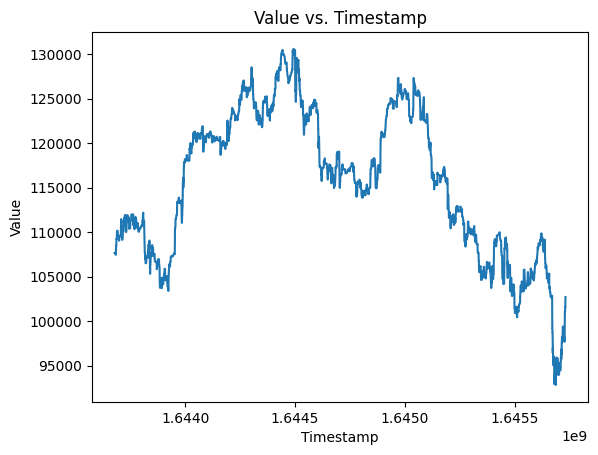

In [141]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(merged2_df['ts'], merged2_df['value'])
ax.set_title('Value vs. Timestamp')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')
#fig.savefig('value_vs_timestamp.png', dpi=300)

In [105]:
results2['value'] = 2*results2['reserve0']/10**18

In [118]:
results2

,ts,reserve0,reserve1,value
0,0,100000000000000000000000,666666666666666666666666,200000.0
1,1620179783,100000000000000000000119,666666666666666666337058,200000.0
2,1620203006,100000000000000000059141,666666666666666501642566,200000.0
3,1620208251,100000000000000000059259,666666666666666501313397,200000.0
4,1620215997,100000000000000000059260,666666666666666501313395,200000.0
...,...,...,...,...
9996,1621203879,100000000000635081901513,666666664894512286610046,200000.000001
9997,1621203921,100000000000635110689046,666666664894431956888669,200000.000001
9998,1621204009,100000000000635648302645,666666664892931781401608,200000.000001
9999,1621204016,100000000000635672393872,666666664892864556413168,200000.000001


Text(0, 0.5, 'Value')

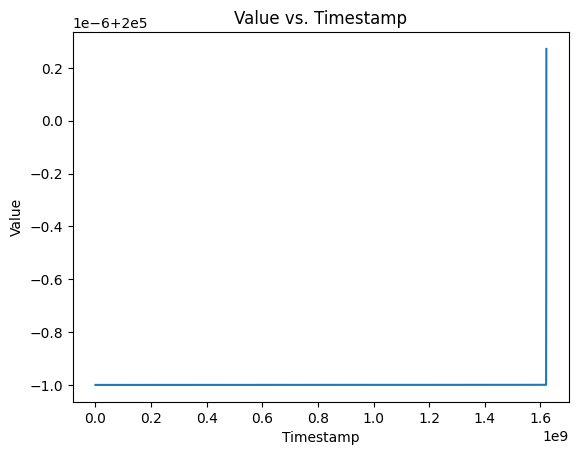

In [108]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(results2['ts'], results2['value'])
ax.set_title('Value vs. Timestamp')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')
#fig.savefig('value_vs_timestamp.png', dpi=300)
